# PROBLEM DESCRIPTION

## Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

## Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

## Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

## Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [36]:
from scipy import stats
import pandas as pd
import numpy as np
import os
import seaborn as sns   
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from uszipcode import SearchEngine
from functools import lru_cache
from sklearn.cluster import KMeans
from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    silhouette_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, 
                             RandomForestClassifier,
                             AdaBoostClassifier, 
                             GradientBoostingClassifier,
                             StackingClassifier)
from sklearn import metrics
from xgboost import XGBClassifier
from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering 
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points
sns.set(color_codes=True) # adds a nice background to the graphs


DEFAULT_SHEET_NAME = "Sheet1"
RANDOM_STATE=1

In [37]:
def load_dataframe_from_xlsx(xlsx_file_name:str)->pd.DataFrame: 
    """Load a xlsx file and return a pandas dataframe.

    Parameters
    ----------
    xlsx_file_name : str
        The csv file

    Return
    ------
    data_frame : DataFrame
        Pandas data frame

    Raises
    ------
    AssertionError
        If the file type is not of type csv
    """

    file_name = str(xlsx_file_name)
    _,file_type=os.path.splitext(file_name)
    assert file_type == '.xlsx',f"File format should be of type xlsx instead of format {file_type}"

    data_frame = pd.read_excel(io=xlsx_file_name,sheet_name=DEFAULT_SHEET_NAME)
    return data_frame

def print_frame_meta_info(data_frame:pd.DataFrame): 
    """Load a data frame file and print meta info of the data frame.

    Parameters
    ----------
    data_frame : DataFrame
    """
    rows,columns = np.shape(data_frame)
    print(f"Shape of the data frame is: {rows},{columns}")
    print(f"Number of variables are: {columns}")
    print("Memory Usage:"+str(data_frame.memory_usage(index=False,deep=True).sum()*0.001))
    print("")
    print("")

    
    for column in data_frame.columns:
        print(f"Name of the column: {column}")
        data_in_column = data_frame[column]
        unique_values = np.unique(data_in_column)
        print("Memory Usage:"+str(data_in_column.memory_usage()*0.001))
        num_values = len(unique_values)
        print(f"Number of unique values:{num_values}")
        if num_values<=50:
            print(f"The unique values:{unique_values}")
        print("")

def box_plot_num_columns(columns):
    """For the provided columns do a box plot.
    
    Parameters
    ----------
    columns : column names
    """
    plt.figure(figsize=(30, 30))

    for idx, variable in enumerate(columns):
        plt.subplot(5, 5, idx + 1)
        sns.boxplot(data=data[variable])
        plt.tight_layout()
        plt.title(variable)

    plt.show()

def treat_outliers(df, col):
    """
    Treats outliers in a variable

    df: dataframe
    col: dataframe column
    """
    Q1 = df[col].quantile(0.25) 
    Q3 = df[col].quantile(0.75)  
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

   
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


def treat_all_outliers(df, num_cols):
    """
    Treat outliers in a list of variables

    df: dataframe
    col_list: list of dataframe columns
    """
    for c in num_cols:
        df = treat_outliers(df, c)
    return df

def draw_bar_plot(x,y):
    """
    Draw bar plot for any 2 features of the table

    x: feature x
    y: feature y
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(15.7, 5.27)
    ax = sns.barplot(x=x,y=y)

def scale_data(data):
    """Scale the data using the z score method and return it"""
    return data.apply(zscore)

def draw_pair_plot(data):
    """Draw pair plot for the entire dataset"""
    sns.set(font_scale = 1)
    sns.pairplot(data,diag_kind='kde')


def plot_elbow_curve(data):
    """Take a dataframe and plot a elbow curve by applying k means on range 1 to 10."""
    data=data.copy()
    cluster_range=range(1,10)
    meanDistortions=[]

    for k in cluster_range: 
        # Make your cluster model
        model=KMeans(n_clusters=k,random_state=RANDOM_STATE)
        # fit it to the data
        model.fit(data)
        # Now do the prediction on the same data
        prediction=model.predict(data)
        # accumulate the mean distortions
        meanDistortions.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])

    # Plot the results.
    plt.plot(cluster_range, meanDistortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average distortion')
    plt.title('Elbow curve for the dataset')

def apply_k_means_clustering(data,num_clusters,append_clusters=False):
    """Apply kmeans for n clusters on a dataset and return the model.
    Optinally, if append_clusters is true, append the cluster prediction to the data and return it too."""
    data=data.copy()
    # Instantiate the model
    model=KMeans(n_clusters=num_clusters,random_state=RANDOM_STATE)
    # Fit to the dataset
    model.fit(data)
    # Now return the prediction
    prediction = model.predict(data)
    # return it
    
    if append_clusters:
        data["clusters"]=prediction
        return model,data
    else:
        return model

def estimate_silhouette_score(data,model):
    "Estimate the silhouette score for a k means model"
    score = silhouette_score(X=data_scaled,
                             labels=model.labels_)
    print(f"Silhouette score for the provided dataset is {score}")
    return score

def apply_hierachial_clustering(data:pd.DataFrame,
                                method:str)->float:
    """Apply Hierachial clustering with the specified linkage method and
    also return the Z score."""
    Z = linkage(data_scaled, metric='euclidean', method=method)
    # Check cophenetic correlation
    c_score, _ = cophenet(Z , pdist(data_scaled))

    plt.figure(figsize=(10, 5))
    plt.title('Hierarchical Clustering Dendogram')
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    dendrogram(Z)
    plt.tight_layout()
    
    return c_score

In [38]:
# load the dataset
raw_data = load_dataframe_from_xlsx("credit_card.xlsx")
# create a copy, where we can work with for the analysis
data = raw_data.copy(deep=True)

In [39]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


<a id='removing_unnecessary_features'></a>
# Removing the Sl_No and Customer Key feature

In [40]:
# Dropping the Sl_No column as it does not add any meaningful information to our analysis.
data.drop(['Sl_No'],axis=1,inplace=True)

# Dropping the Customer Key column as it does not add any meaningful information to our analysis.
data.drop(['Customer Key'],axis=1,inplace=True)


<a id='check_missing_values'></a>
# Check if there are any missing values

In [41]:
# Let's see if the dataset has any missing value
data.isnull().sum().sort_values(ascending=False)

Total_calls_made       0
Total_visits_online    0
Total_visits_bank      0
Total_Credit_Cards     0
Avg_Credit_Limit       0
dtype: int64

# Inspect the meta of the dataset

In [42]:
print_frame_meta_info(data)

Shape of the data frame is: 660,5
Number of variables are: 5
Memory Usage:26.400000000000002


Name of the column: Avg_Credit_Limit
Memory Usage:5.408
Number of unique values:110

Name of the column: Total_Credit_Cards
Memory Usage:5.408
Number of unique values:10
The unique values:[ 1  2  3  4  5  6  7  8  9 10]

Name of the column: Total_visits_bank
Memory Usage:5.408
Number of unique values:6
The unique values:[0 1 2 3 4 5]

Name of the column: Total_visits_online
Memory Usage:5.408
Number of unique values:16
The unique values:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

Name of the column: Total_calls_made
Memory Usage:5.408
Number of unique values:11
The unique values:[ 0  1  2  3  4  5  6  7  8  9 10]



# Univariate Analysis

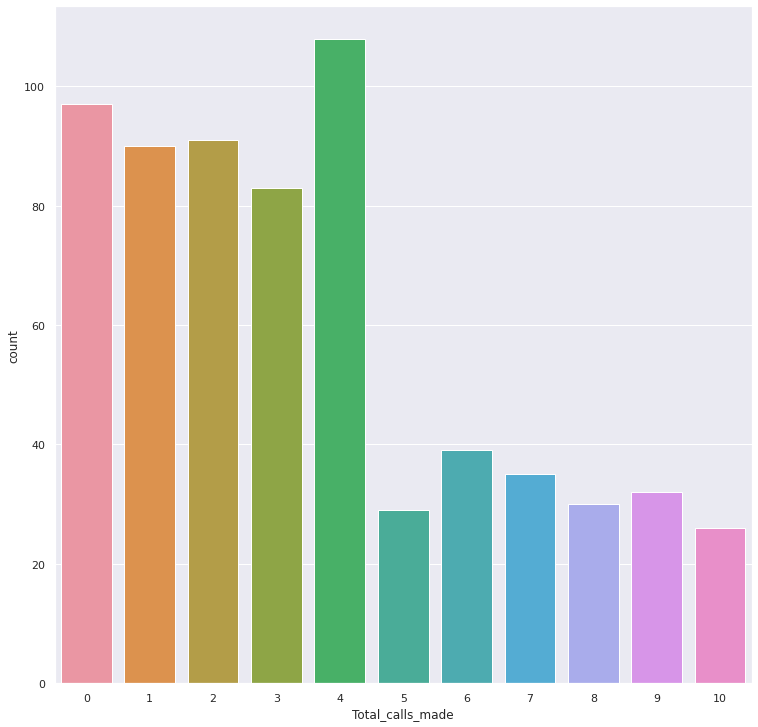

Number of customers who has 0 Total_calls_made: 97
Number of customers who has 9 Total_calls_made: 32
Number of customers who has 4 Total_calls_made: 108
Number of customers who has 3 Total_calls_made: 83
Number of customers who has 8 Total_calls_made: 30
Number of customers who has 2 Total_calls_made: 91
Number of customers who has 1 Total_calls_made: 90
Number of customers who has 7 Total_calls_made: 35
Number of customers who has 5 Total_calls_made: 29
Number of customers who has 6 Total_calls_made: 39
Number of customers who has 10 Total_calls_made: 26


In [43]:
col_name = "Total_calls_made"
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x=col_name, data=data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for status in data[col_name].unique():
    print(f"Number of customers who has {status} {col_name}: {len(data[(data.get(col_name) == status)])}")

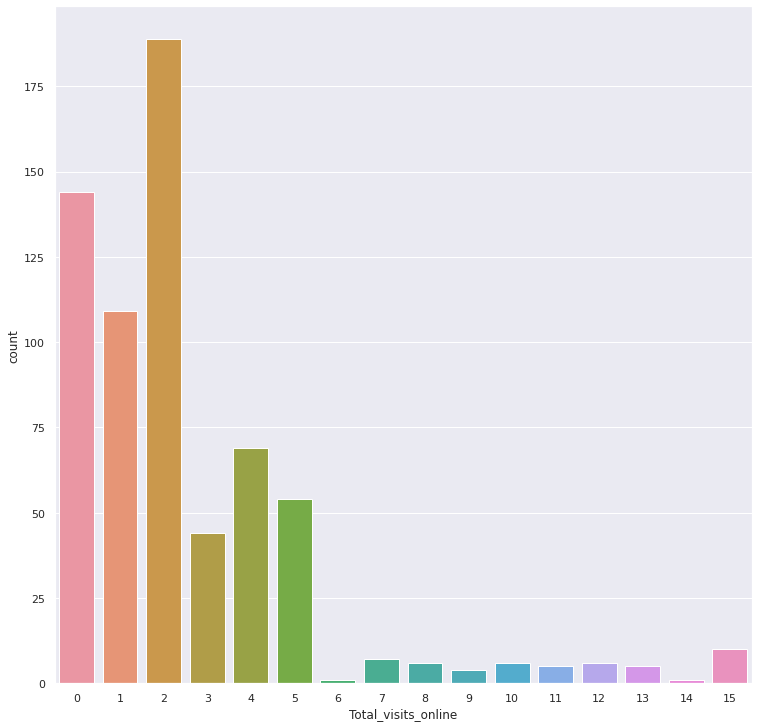

Number of customers who has 1 Total_visits_online: 109
Number of customers who has 10 Total_visits_online: 6
Number of customers who has 3 Total_visits_online: 44
Number of customers who has 12 Total_visits_online: 6
Number of customers who has 11 Total_visits_online: 5
Number of customers who has 2 Total_visits_online: 189
Number of customers who has 5 Total_visits_online: 54
Number of customers who has 4 Total_visits_online: 69
Number of customers who has 0 Total_visits_online: 144
Number of customers who has 14 Total_visits_online: 1
Number of customers who has 7 Total_visits_online: 7
Number of customers who has 13 Total_visits_online: 5
Number of customers who has 15 Total_visits_online: 10
Number of customers who has 6 Total_visits_online: 1
Number of customers who has 8 Total_visits_online: 6
Number of customers who has 9 Total_visits_online: 4


In [44]:
col_name = "Total_visits_online"
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x=col_name, data=data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for status in data[col_name].unique():
    print(f"Number of customers who has {status} {col_name}: {len(data[(data.get(col_name) == status)])}")

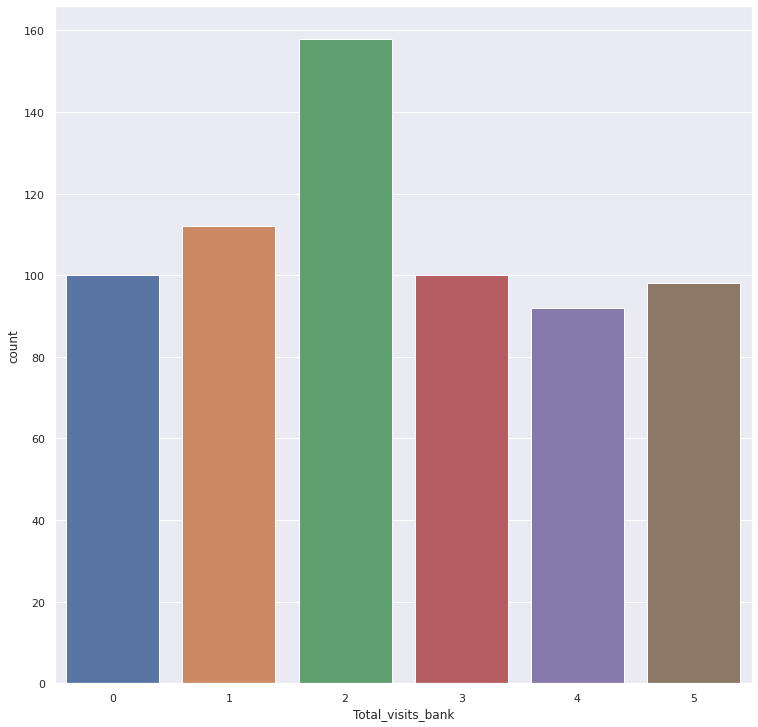

Number of customers who has 1 Total_visits_bank: 112
Number of customers who has 0 Total_visits_bank: 100
Number of customers who has 2 Total_visits_bank: 158
Number of customers who has 5 Total_visits_bank: 98
Number of customers who has 3 Total_visits_bank: 100
Number of customers who has 4 Total_visits_bank: 92


In [45]:
col_name = "Total_visits_bank"
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x=col_name, data=data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for status in data[col_name].unique():
    print(f"Number of customers who has {status} {col_name}: {len(data[(data.get(col_name) == status)])}")

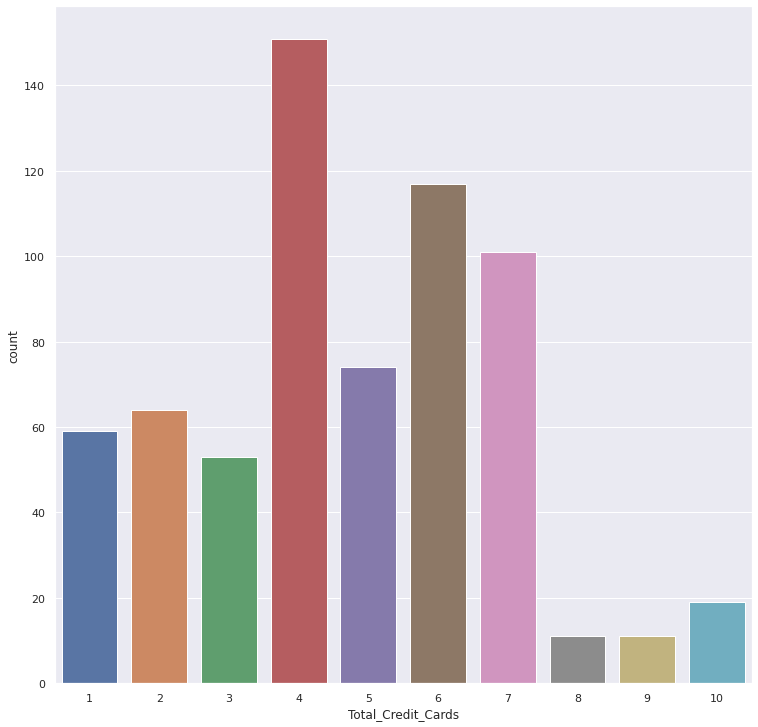

Number of customers who has 2 Total_Credit_Cards: 64
Number of customers who has 3 Total_Credit_Cards: 53
Number of customers who has 7 Total_Credit_Cards: 101
Number of customers who has 5 Total_Credit_Cards: 74
Number of customers who has 6 Total_Credit_Cards: 117
Number of customers who has 4 Total_Credit_Cards: 151
Number of customers who has 1 Total_Credit_Cards: 59
Number of customers who has 9 Total_Credit_Cards: 11
Number of customers who has 8 Total_Credit_Cards: 11
Number of customers who has 10 Total_Credit_Cards: 19


In [46]:
col_name = "Total_Credit_Cards"
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x=col_name, data=data)
ax.set_xticklabels(ax.get_xticklabels())
plt.tight_layout()
plt.show()


for status in data[col_name].unique():
    print(f"Number of customers who has {status} {col_name}: {len(data[(data.get(col_name) == status)])}")

Univariate Analysis of Avg_Credit_Limit
Max Avg_Credit_Limit is 200000
Min Avg_Credit_Limit is 3000
Mean Avg_Credit_Limit is 34574.242424242424


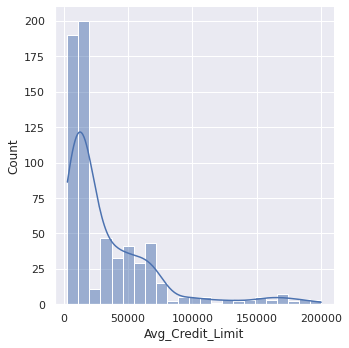

In [47]:
col_name = "Avg_Credit_Limit"
print(f"Univariate Analysis of {col_name}")
data_points = data.get(col_name)
sns.displot(data_points,kde=True);
print(f"Max {col_name} is {np.max(data_points)}")
print(f"Min {col_name} is {np.min(data_points)}")
print(f"Mean {col_name} is {np.mean(data_points)}")

# BI VARIATE ANALYSIS

<AxesSubplot:>

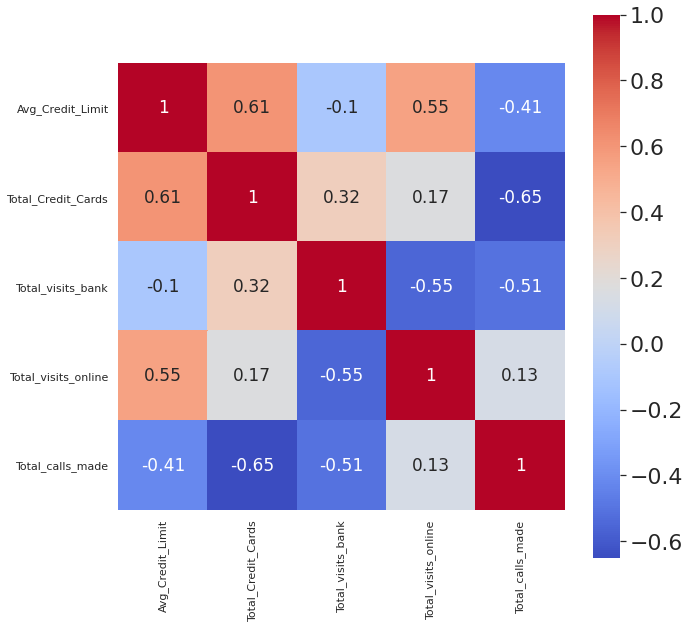

In [48]:
# plot the correlation coefficients 
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale = 2)
sns.heatmap(data.corr(), 
            annot=True,
            ax=ax ,
            cbar=1, 
            square=1, 
            annot_kws={'size': 17}, 
            cmap= 'coolwarm')

# Observations from the correlation matrix (above)

- Strong +ve correlation between average credit limit and total credit cards. (Makes sense, more cards then higher the spending)

- Decent +ve correlation between average credit limit and total visits online (Makes sense, more the spending then visiting more online to check on spending)

- Decent -ve correlation between average credit limit and total calls made (Maybe lesser credit means, more interaction with the bank to increase it)

- Strong -ve correlation between total credit cards and total calls made. (Maybe if lesser cards, more calls to the bank, since a new user initially or to ask for more cards)

- Decent -ve correlation between total visits to the bank and total visits online (makes sense, if you visit more in person, then less checking the info online)

- Decent -ve correlation between total visits to the bank and total calls made (makes sense, if you visit more in person, then less calling the bank for the same info)


# Observation between Total_Credit_Cards and Total_calls_made
- Higher the number of cards lesser the calls.
- Reason might be to get more cards and get to know more about the bank.
- Reach out to the bank, to know if there is any offer on newer cards

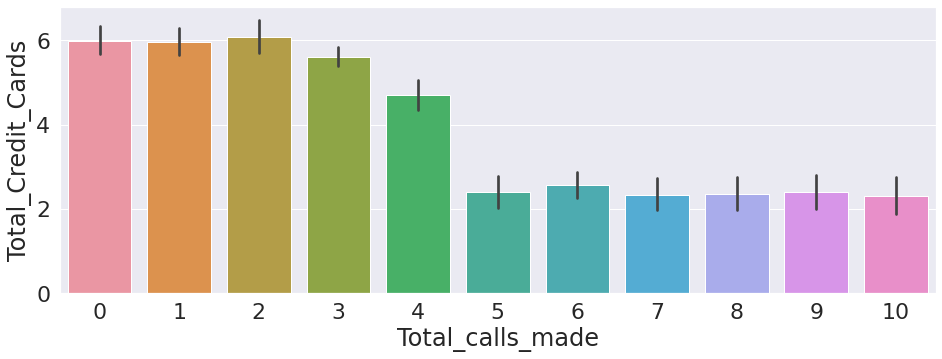

In [49]:
draw_bar_plot(y=data["Total_Credit_Cards"],
              x=data["Total_calls_made"])

# Observation between Total_Credit_Cards and Total_visits_online
- Apparently higher the number of cards, the more you see online about its purcahse etc.
- Also people with 1 to 3 cards visit more often people with 4 to 7 cards, probably because they are new users.

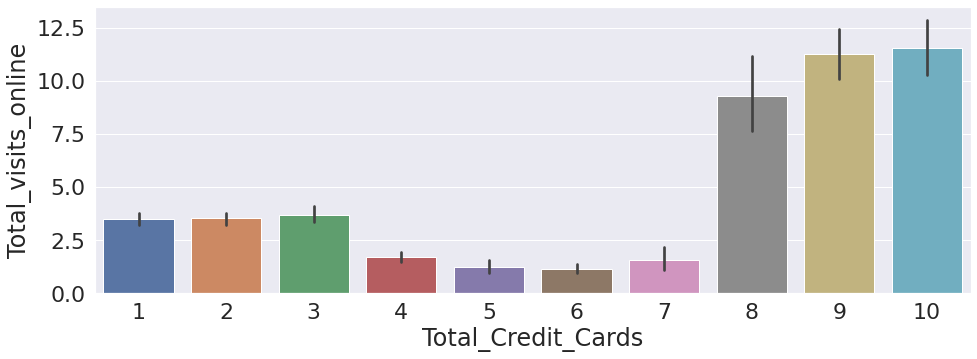

In [50]:
draw_bar_plot(x=data["Total_Credit_Cards"],
              y=data["Total_visits_online"])

# Observation between Total_Credit_Cards and Total_visits_bank
 - Total vists to the bank is more with more credit cards.
 - Folks who did not vist the bank, have the least number of cards.

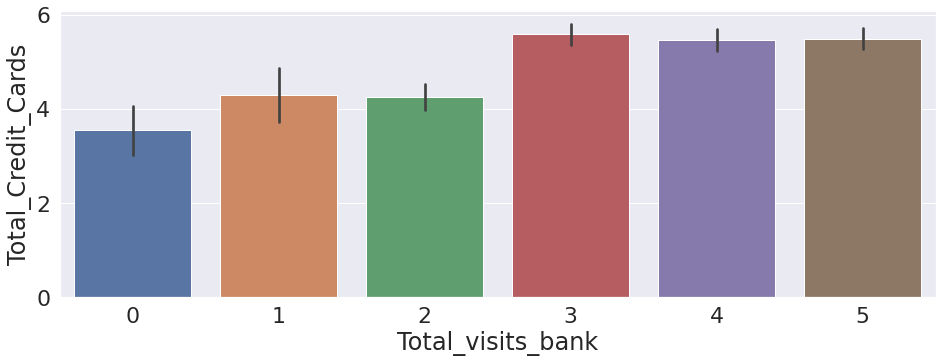

In [51]:
draw_bar_plot(y=data["Total_Credit_Cards"],
              x=data["Total_visits_bank"])

# Observation between Total_visits_bank and average_credit_limit
 - Folks with higher average credit limit, tend to visit the bank less.
 - Folks with lesser average credit limit, tend to go to bank more to ask for higher credits

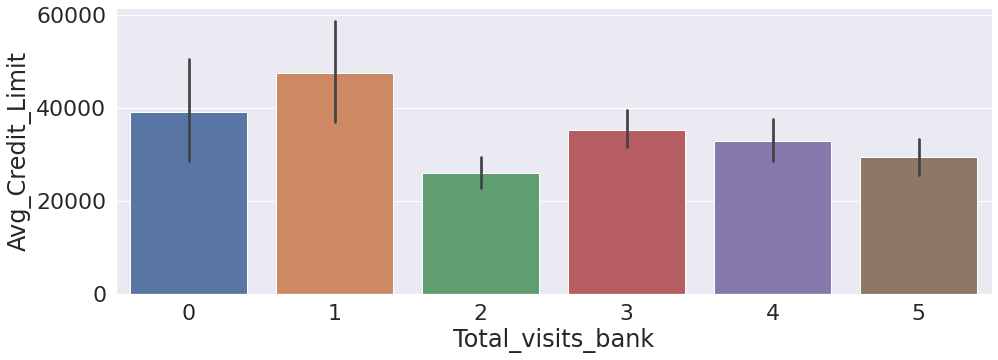

In [52]:
draw_bar_plot(y=data["Avg_Credit_Limit"],
              x=data["Total_visits_bank"])

# Observation between average_credit_limit and Total_Credit_Cards
 - The more number of cards, more spending and higher the credit limit.

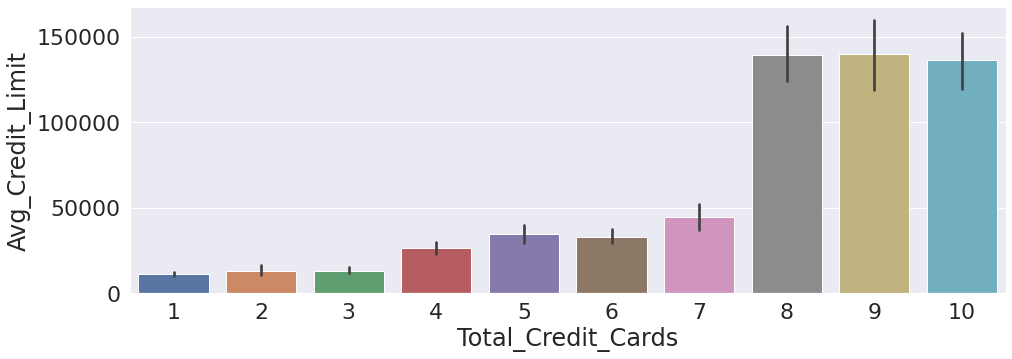

In [53]:
draw_bar_plot(y=data["Avg_Credit_Limit"],
              x=data["Total_Credit_Cards"])

# Observation between average_credit_limit and total_visits_online
 - The higher the credit limit, the more visits online to check the status etc

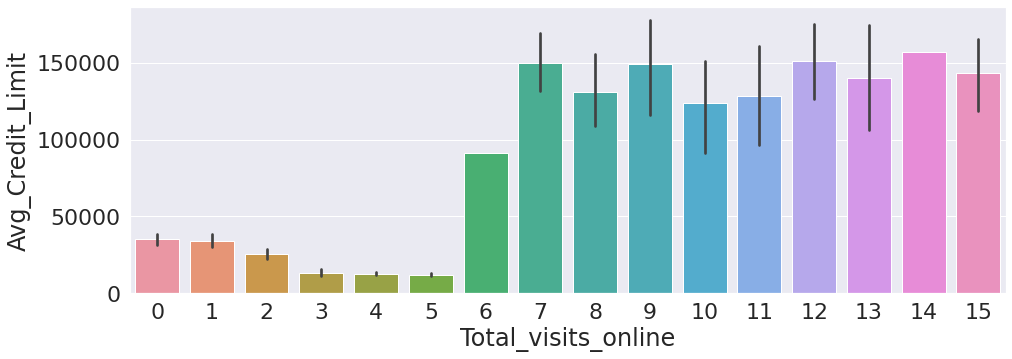

In [54]:
draw_bar_plot(y=data["Avg_Credit_Limit"],
              x=data["Total_visits_online"])

# Observation between average_credit_limit and total_visits_online
 - The higher the credit limit, the less calls made to increase it.
 - Customers with lower limit may call the bank more to ask for more credit.
 - or new users with lesser credit limit may call the bank more to understand the system well

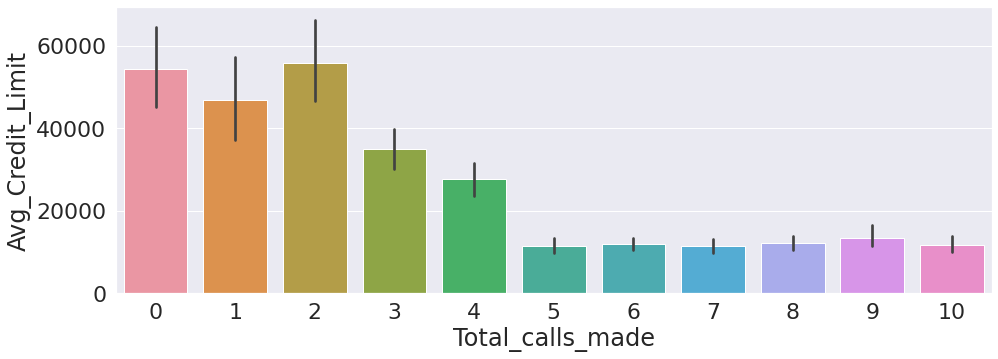

In [55]:
draw_bar_plot(y=data["Avg_Credit_Limit"],
              x=data["Total_calls_made"])

# Observation between Total_visits_bank and Total_visits_online
 - Total number of visits to the bank is lesser when visited online (as one can get the same info there)

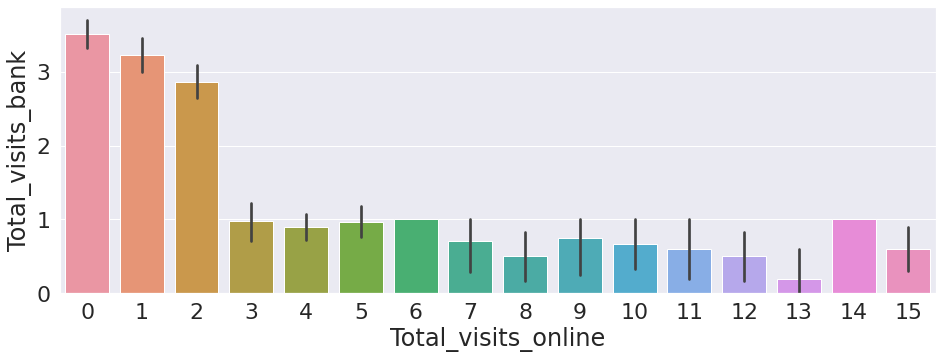

In [56]:
draw_bar_plot(y=data["Total_visits_bank"],
              x=data["Total_visits_online"])

# Observation between Total_visits_bank and Total_visits_online
 - Total number of visits to the bank is less, if there are a lot of calls made to talk to the bank's customer service.

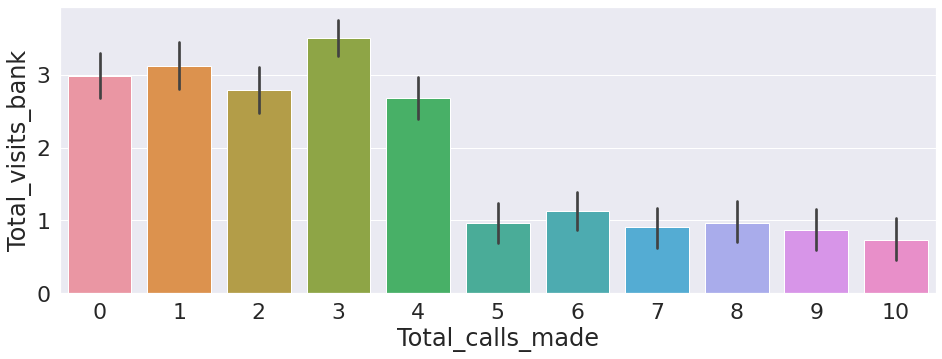

In [57]:
draw_bar_plot(y=data["Total_visits_bank"],
              x=data["Total_calls_made"])

# Observation between Total_visits_bank and Total_visits_online
 - Total number of visits to the bank is less, if there are a lot of visits online to know the same information

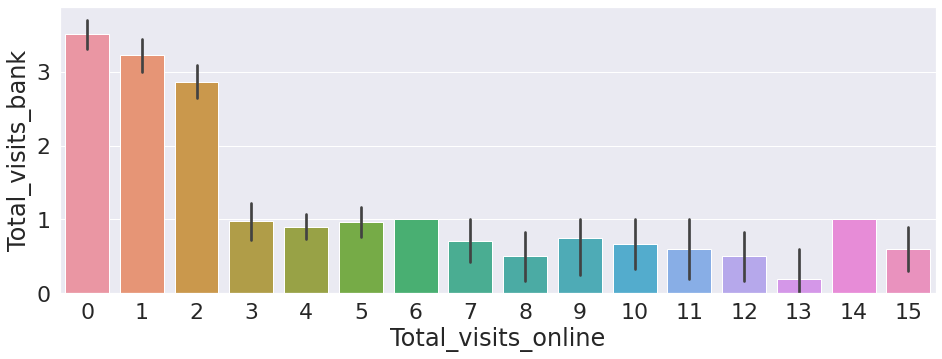

In [58]:
draw_bar_plot(y=data["Total_visits_bank"],
              x=data["Total_visits_online"])

# Data preprocessing

## Missing Value treatment
There are no missing value to be treated as seen here ([check_missing_values](#check_missing_values))

## Data prep work - removing unwanted features
Here is the link: [remove unwanted features](#removing_unnecessary_features) (to a previous cell)

# Outlier treatment 
## Check presence of outlier

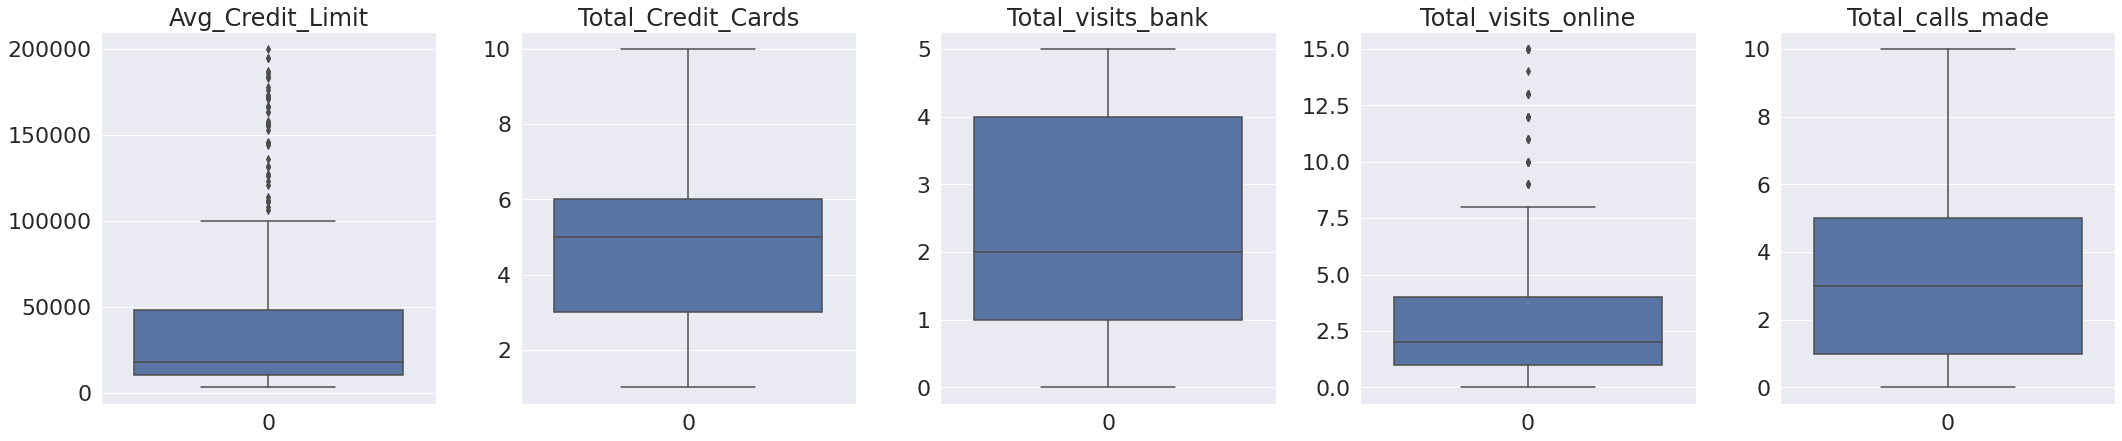

In [59]:
# Get the list of numerical columns
numerical_col = data.select_dtypes(include=np.number).columns.tolist()
box_plot_num_columns(numerical_col)

# Discussion on outliers (based on the plots above):

- Avg_Credit_Limit: **494** entries fall in this outlier, and that is a good chunk to consider for clustering
- Total_visits_online: **37** entries represent these outliers and they do represent good chunk as well (so will be considered for clustering)

# Check for skewness in the data

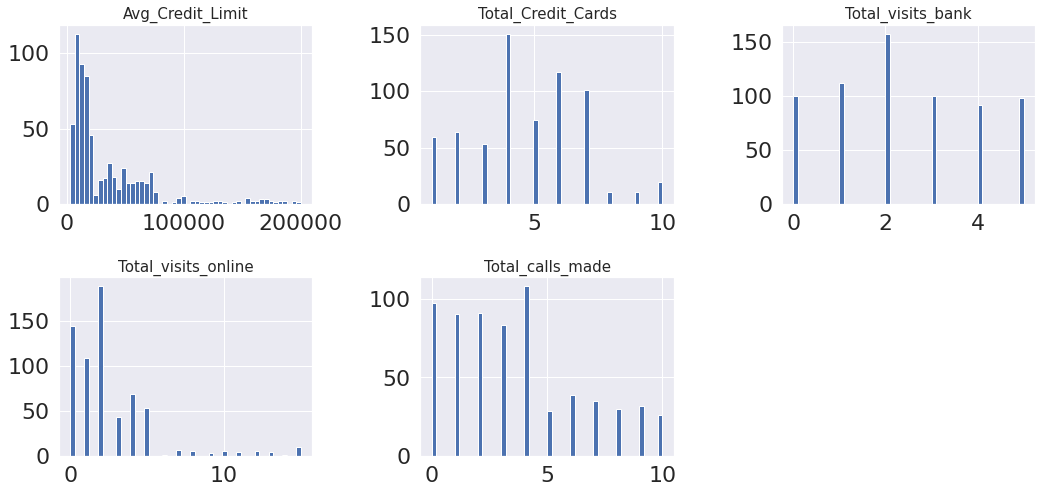

In [60]:
# creating a list of numerical columns
num_cols = [
    num_col for num_col in data.select_dtypes(include=np.number).columns
]

plt.figure(figsize=(15, 35))

# then plot the numerical columns.
for i in range(len(num_cols)):
    plt.subplot(10, 3, i + 1)
    plt.hist(data[num_cols[i]], bins=50)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=15)

plt.show()

# Clustering


## Clustering - Drawing pairplot and some observations

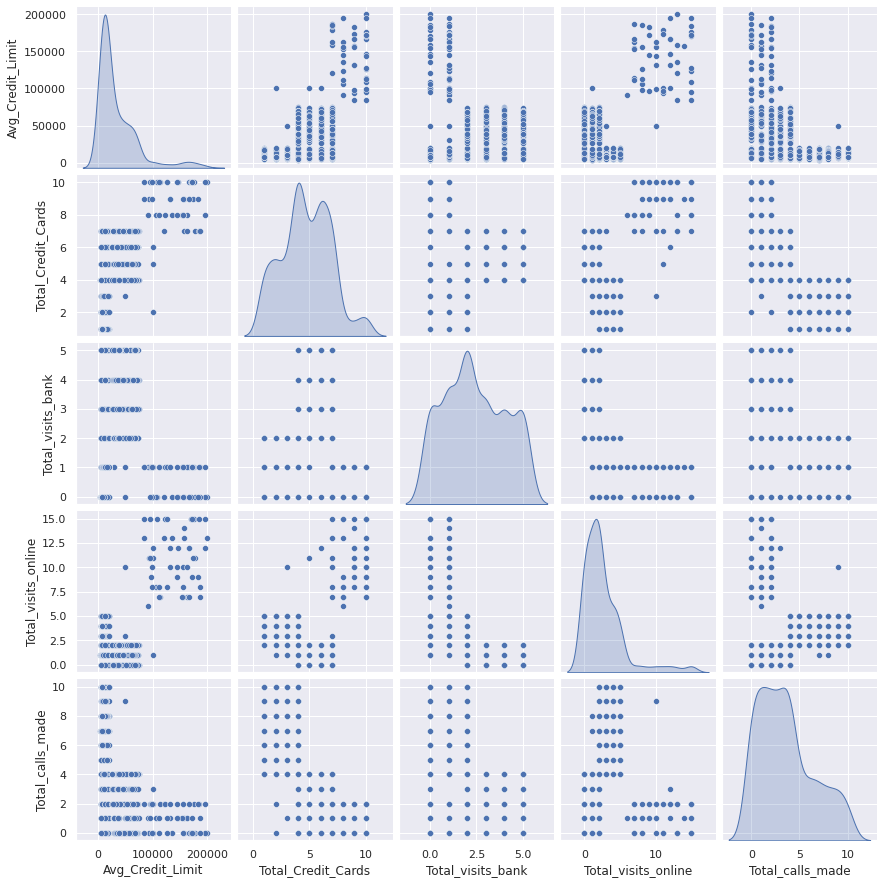

In [61]:
# scale the dataset first
data_scaled=scale_data(data)
# now draw the pair plot
draw_pair_plot(data)

## Pairplot observations from the plot above
Before we get into clustering, lets do a pairplot and get some inital observations.
 - Looking at the diagonal plots:
    - Total credit cars might have 3 to 4 segments
    - Nothing clear with total visits bank
    - Total visits online might have 2 segments
    - Total calls made might have 2 segments
    - Average credit limit log might have 2 segments.

## Clustering - Kmeans - Elbow curve

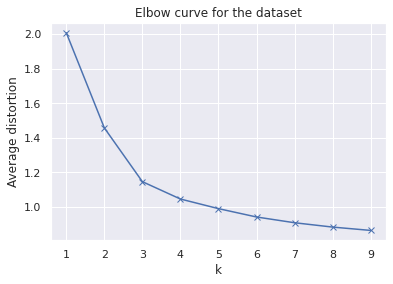

In [62]:
plot_elbow_curve(data_scaled)

## Clustering - Kmeans - Observations from the elbow curve above
There is clear bend, starting from **3**. So lets choose **3** as the number of clusters.
But will check the silhouette from a range of 2 to 9.

## Clustering - Kmeans - Checking the silhouette scores

In [63]:
for num_cluster in range(2,9):
    model,data_cluster_info = apply_k_means_clustering(data=data_scaled,
                                                       num_clusters=num_cluster,
                                                       append_clusters=True)
    print(f"Number of clusters:{num_cluster}")
    estimate_silhouette_score(data=data_scaled,model=model)
    print("")

Number of clusters:2
Silhouette score for the provided dataset is 0.41842496663215445

Number of clusters:3
Silhouette score for the provided dataset is 0.5157182558881063

Number of clusters:4
Silhouette score for the provided dataset is 0.3556670619372605

Number of clusters:5
Silhouette score for the provided dataset is 0.2717470361089752

Number of clusters:6
Silhouette score for the provided dataset is 0.255906765297388

Number of clusters:7
Silhouette score for the provided dataset is 0.24798644656011146

Number of clusters:8
Silhouette score for the provided dataset is 0.2414240144760896



## Clustering - Kmeans -  Figure out appropriate number of clusters
Based on the output, it is clear that we go with 3 as the number of clusters, since it has the highest score (**0.51571825**)

## Clustering: Cluster profiling

array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[clusters]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[clusters]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[clusters]'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

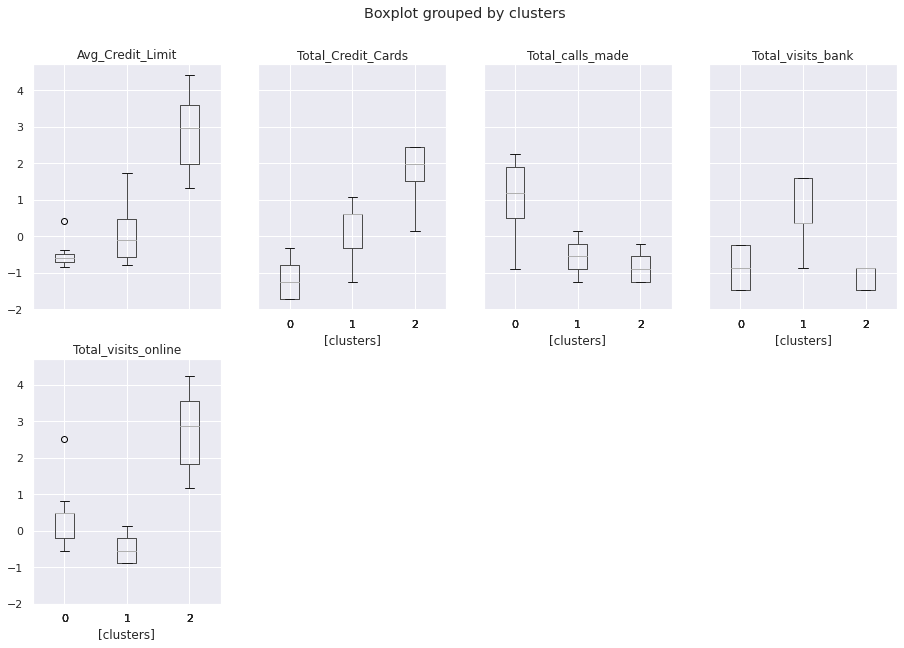

In [64]:
model,data_cluster_info = apply_k_means_clustering(data=data_scaled,
                                                   num_clusters=3,
                                                   append_clusters=True)
data_cluster_info.boxplot(by='clusters', layout = (2,4),figsize=(15,10)) 

<a id='k_means_clustering_discussion'></a>

## Clustering: Kmeans - Cluster profiling discussion (based on the plots above)

- Avg_Credit_Limit:
   - Cluster 3 has higher credit limit
   - Cluster 2 second highest (some what mid level) credit limit
   - Cluster 1 has the lowest credit limit
- Total_Credit_Cards:
   - Cluster 3 has high number of card holders
   - Cluster 2 has second highest number (some what mid level) of card holders
   - Cluster 1 has the lowest
- Total_calls_made:
   - Cluster 1 has the highest number of calls made category.
   - cluster 2 has mid level number of calls made
   - cluster 3 has the lowest
- Total_visits_bank:
  - Cluster 1 has the mid level number of visits category
  - cluster 2 contains the highest number of visits to the bank
  - cluster 3 has the lowest
- Total_visits_online:
  - Cluster 1 has the mid level of visits online.
  - Cluster 2 represents lowest number of visits
  - Cluster 3 represents the highest
    

# Hierachial clustering

## Hierachial clustering - Average Linkage method results

Correlation score for method: average is 0.8977080867389372


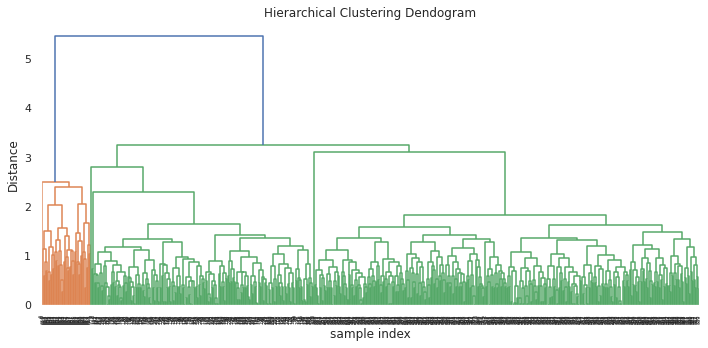

In [65]:
method = "average"
correlation_score = apply_hierachial_clustering(data=data_scaled,method=method)
print(f"Correlation score for method: {method} is {correlation_score}")

## Hierachial clustering - Single linkage method results

Correlation score for method: single is 0.7391220243806552


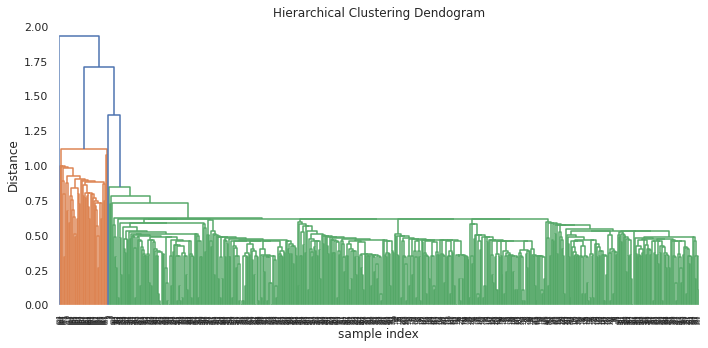

In [66]:
method = "single"
correlation_score = apply_hierachial_clustering(data=data_scaled,method=method)
print(f"Correlation score for method: {method} is {correlation_score}")

## Hierachial clustering - Ward linkage method results

Correlation score for method: ward is 0.7415156284827491


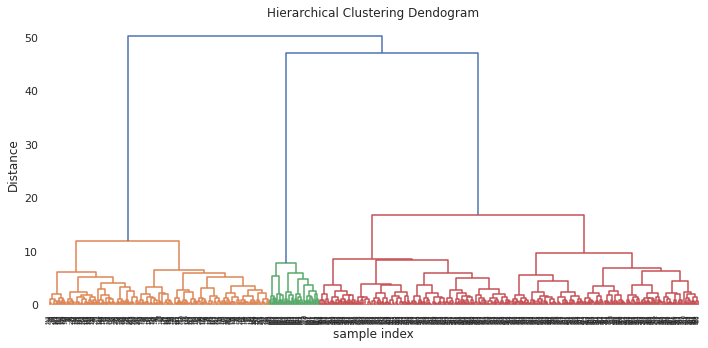

In [67]:
method = "ward"
correlation_score = apply_hierachial_clustering(data=data_scaled,method=method)
print(f"Correlation score for method: {method} is {correlation_score}")

## Hierachial clustering - Complete linkage method results

Correlation score for method: complete is 0.8599730607972423


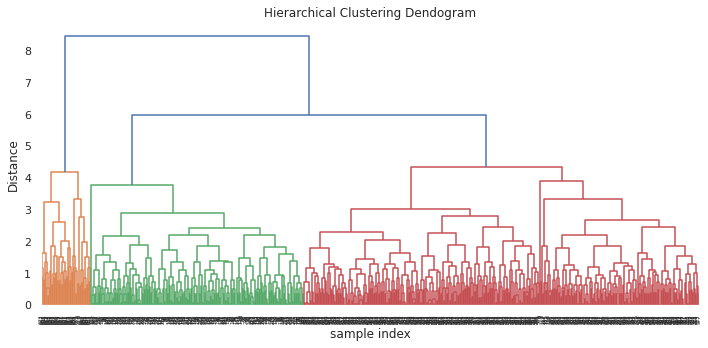

In [68]:
method = "complete"
correlation_score = apply_hierachial_clustering(data=data_scaled,method=method)
print(f"Correlation score for method: {method} is {correlation_score}")

## Hierachial clustering - Weighted linkage method results

Correlation score for method: weighted is 0.8861746814895477


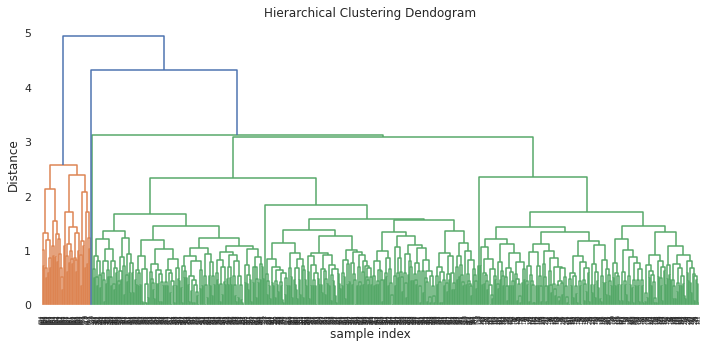

In [69]:
method = "weighted"
correlation_score = apply_hierachial_clustering(data=data_scaled,method=method)
print(f"Correlation score for method: {method} is {correlation_score}")

## Hierachial clustering - Discussion (based on the results above)
Based on the results above, the methods **Complete, weighted and average** has the best correlation with the dataset. Based on these methods, it seems to indicate we might **2 to 3** clusters from the dataset. 

## Hierachial clustering - Cluster profiling with "Average" linkage method (since it has the highest correlation score)

The silhouette score is 0.515922432650965


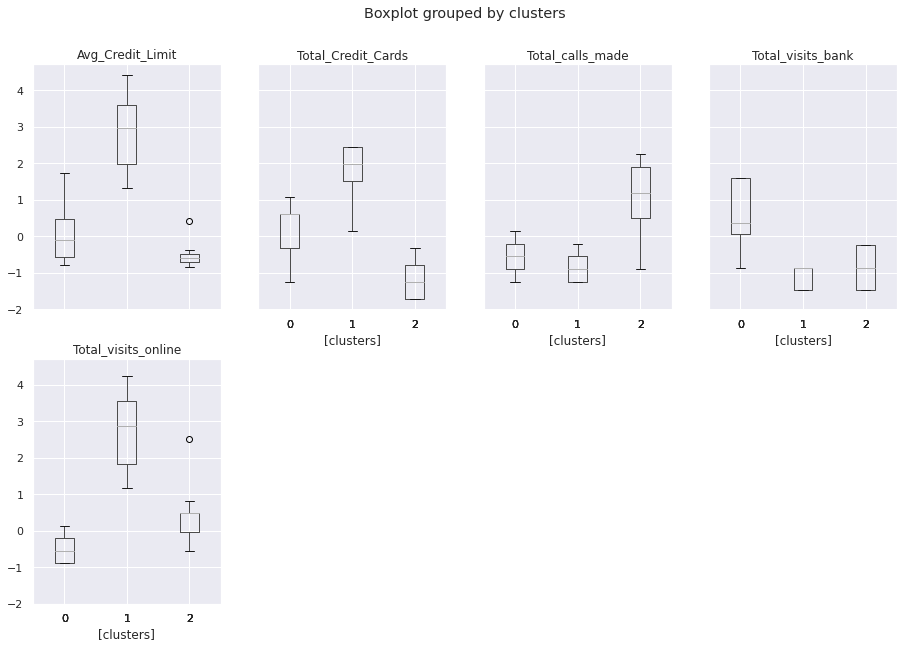

In [70]:
# Make the model first
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
model.fit(data_scaled)
heir_data=data_scaled.copy()
# Assign the lables of the cluster
heir_data['clusters'] = model.labels_
# Analyze the clusters
heir_data.boxplot(by='clusters', layout = (2,4),figsize=(15,10)) 
# Check the silhoutte score
score = silhouette_score(X=data_scaled,
                        labels=model.labels_)
print(f"The silhouette score is {score}")

## Hierachial clustering - Cluster profiling - discussion
- Based on the results above, similar to **K-means clustering** results, we have **3** clear clusters. 

- For example in **Avg_cedit_limit**, has 
  - 1st cluster with medium credit limit holders
  - 2nd cluster have the highest credit limit holders
  - The 3rd cluster is least credit limit holders.
- The silhouette score is **0.515922432650965**

# K-means vs Hierarchical Clustering
 - The silhouette score from hierachial clustering method ("average linkage") is **0.515922432650965**.
 - The highest silhouette score from K-means clustering method is **0.51571825**.
 - As we see the hierachial has a slightly better score.
 - Should we go with Kmeans or Hierachial?:
   - Based off of the silhouette score, the K means and Hierachial are almost similar in performance
   - If the size of the dataset further increases, hierarchical clustering willt take more space and time compared to k means clustering
   - So the verdict is to go with K means clustering considering scalability in the future.

# Actionable Insights & Recommendations
**Going by the results of K-means clustering as discussed [here](#k_means_clustering_discussion):**

- **Cluster_1**: 
  - Represents folks with 0 to very minimal credit cards.
  - This cluster characterizes folks who have the least average credit and have been calling the bank a lot to get better benefits. 
  - Customer care should be specifically focused on cluster 1 folks (and give more patience and time and also being listened too).
  
- **Cluster_2**:
   - These are the people with minimal number of cards and have been visiting the bank a lot.
   - Onsite customer care team in the bank should be more eager to interact with this customers (since they visit the bank a lot) and discuss on better card options offered by the bank.
   - These customers can also be reached through email for better card options.
 
- **Cluster_3**:
   - These folks have the highest credit. Highest number of cards and least interactions with the bank.
   - I don't think customers who belong to this cluster require a lot of attention.
   - But these are our **top** customers (with heavy usage of cards), so retaining them is a top priority
   - How do we retain them?
      - Send emails and mails of various cashback deals offered with our cards.
      - Also emphasize (through emails and mails) our growing partnerhsip with different merchant vendors and the benefits which come with it
